In [9]:
import numpy as np
import matplotlib.pyplot as plt

## Large-scale power loss in ground-based CMB mapmaking
Naess, Sigurd ; Louis, Thibaut



In [2]:
npix = 10
nsamp = 100
pix = np.arange(nsamp).astype(float)*npix/nsamp
#A standard nearest-neighbor pointing matrix for this looks like:

P = np.zeros((nsamp,npix))
for i, p in enumerate(pix):
    P[i,int(np.round(pix[i]))%npix] = 1


freq = np.fft.rfftfreq(nsamp)
print(freq)
inv_ps = 1/(1+(np.maximum(freq,freq[1]/2)/0.03)**-3.5)
F = np.zeros((nsamp,nsamp))
I = np.eye(nsamp)
for i in range(nsamp):
    F[:,i] = np.fft.irfft(inv_ps*np.fft.rfft(I[i]), n=nsamp)
#The signal itself consists of just a long-wavelength sine wave:5
print(F[0,0],F[99,99])
signal = np.sin(2*np.pi*pix/npix)


[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 ]
0.931157641667902 0.931157641667902


Text(0, 0.5, '$t_2$')

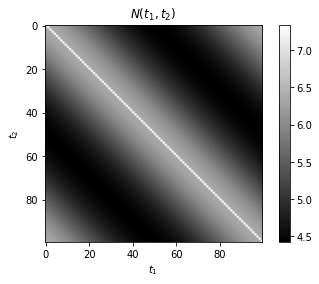

In [3]:
plt.imshow(np.linalg.inv(F), cmap='gray')  # Use 'gray' for grayscale images, or other colormaps
plt.colorbar()  # Add a colorbar to show the value mapping
plt.title('$N(t_1,t_2)$')
plt.xlabel('$t_1$')
plt.ylabel('$t_2$')


Text(0, 0.5, 'Signal')

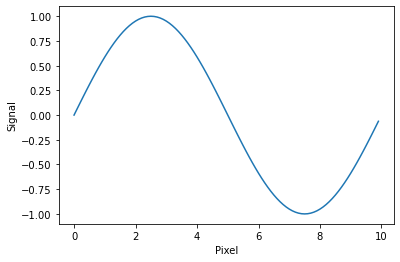

In [4]:
plt.plot(pix,signal)
plt.xlabel('Pixel')
plt.ylabel('Signal')
#plt.plot(range(nsamp),pix)

Text(0.5, 0, 'Time')

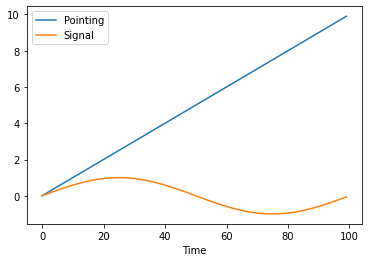

In [5]:
plt.plot(range(nsamp),pix,label='Pointing')
plt.plot(range(nsamp),signal,label='Signal')
plt.legend()
plt.xlabel('Time')

In [6]:
map_binned = np.linalg.solve((P.T.dot(P)), P.T.dot(signal)) ## Solves P^TP (map) = P^T data
map_ml = np.linalg.solve((P.T.dot(F).dot(P)),P.T.dot(F.dot(signal)))
map_fb = np.linalg.solve(P.T.dot(P), P.T.dot(F).dot(signal))
obsmat = np.linalg.inv(P.T.dot(P)).dot(P.T.dot(F).dot(P))
#and using it, we can define a debiased filter+bin map

map_fb_deobs = np.linalg.solve(obsmat, map_fb)

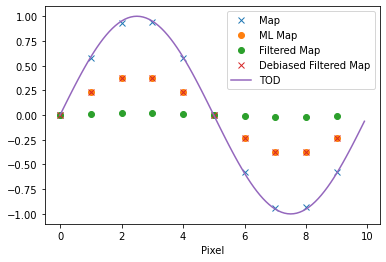

In [7]:
plt.plot(range(npix),map_binned,'x',label='Map')
plt.plot(range(npix),map_ml,'o',label='ML Map')
plt.plot(range(npix),map_fb,'o',label='Filtered Map')
plt.plot(range(npix),map_fb_deobs,'x',label='Debiased Filtered Map')
plt.plot(pix,signal,label='TOD')
plt.xlabel('Pixel')
plt.legend()

## Signal To Noise

In [8]:
# First look at the signal to noise from the above example. Take the signal in each pixel to be the mean of all samples in that pixel.
# What is called signal there is really the data. So add noise to the signal


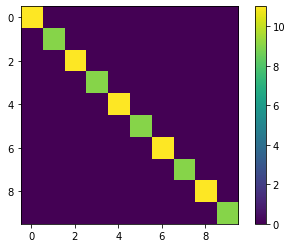

In [9]:
plt.imshow(P.T.dot(P))
plt.colorbar()

In [10]:
for i in range(npix):
    print(P.T.dot(P)[i,i])

11.0
9.0
11.0
9.0
11.0
9.0
11.0
9.0
11.0
9.0


In [11]:

# Define the mean (zero vector)
mean = np.zeros(nsamp)

# Define a random covariance matrix N (must be positive semi-definite)
# Example: Generating a symmetric positive-definite matrix
A = np.random.randn(nsamp, nsamp)
N = np.linalg.inv(F)

# Draw 100 samples from the multivariate normal distribution
noise = np.random.multivariate_normal(mean, N, size=1).flatten()  # Shape: (100,)




In [12]:
data=signal+noise
data_map_binned = np.linalg.solve((P.T.dot(P)), P.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((P.T.dot(F).dot(P)),P.T.dot(F.dot(data)))

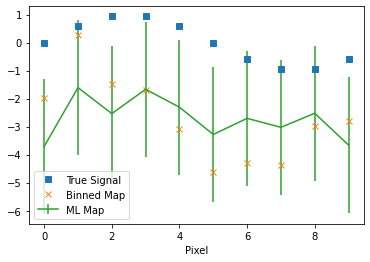

In [13]:
plt.plot(range(npix),map_binned,'s',label='True Signal')
plt.plot(range(npix),data_map_binned,'x',label='Binned Map')
error=np.sqrt(np.diag(np.linalg.inv(P.T.dot(F).dot(P))))
plt.errorbar(range(npix),data_map_ml,yerr=error,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

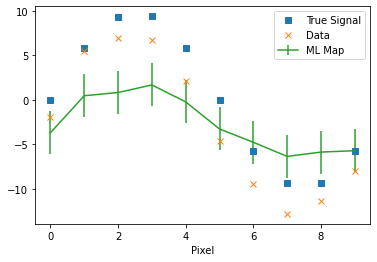

In [14]:
## Suppose the signal to noise is much larger: 
sn=10
signal = sn*np.sin(2*np.pi*pix/npix)
data=signal+noise
data_map_binned = np.linalg.solve((P.T.dot(P)), P.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((P.T.dot(F).dot(P)),P.T.dot(F.dot(data)))
plt.plot(range(npix),sn*map_binned,'s',label='True Signal')
plt.plot(range(npix),data_map_binned,'x',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(P.T.dot(F).dot(P))))
plt.errorbar(range(npix),data_map_ml,yerr=error,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

In [15]:
sigma = 0.5  # Beam width in pixel units
Pw = np.zeros((nsamp, npix))

for i, p in enumerate(pix):
    for j in range(npix):
        Pw[i, j] = np.exp(-0.5 * ((p - j) / sigma) ** 2)  # Gaussian weight

    Pw[i, :] /= np.sum(Pw[i, :])  # Normalize row to sum to 1

print(Pw[:5])


[[8.80536890e-01 1.19167709e-01 2.95387219e-04 1.34105590e-08
  1.11512649e-14 1.69833539e-22 4.73745239e-32 2.42040660e-43
  2.26492524e-56 3.88187447e-71]
 [8.31501844e-01 1.67877327e-01 6.20787476e-04 4.20451514e-08
  5.21568034e-14 1.18502656e-21 4.93136645e-31 3.75862103e-42
  5.24700979e-55 1.34158219e-69]
 [7.67544570e-01 2.31179982e-01 1.27531926e-03 1.28857495e-07
  2.38463835e-13 8.08271817e-21 5.01781239e-30 5.70549693e-41
  1.18821383e-53 4.53229119e-68]
 [6.88218275e-01 3.09236404e-01 2.54493739e-03 3.83606238e-07
  1.05904958e-12 5.35511741e-20 4.95956713e-29 8.41280111e-40
  2.61372290e-52 1.48730671e-66]
 [5.95751703e-01 3.99344309e-01 4.90288582e-03 1.10249881e-06
  4.54073917e-12 3.42528768e-19 4.73248909e-28 1.19757925e-38
  5.55061337e-51 4.71194013e-65]]


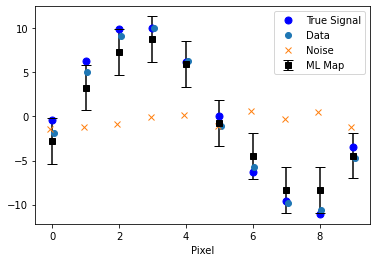

In [16]:
sn=10
signal = sn*np.sin(2*np.pi*pix/npix)
noise = np.random.multivariate_normal(mean, N, size=1).flatten()  # Shape: (100,)
data=signal+noise

map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
noise_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(noise)) ## Solves P^TP (map) = P^T data
data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),map_binned,'ob',ms=7,label='True Signal')
plt.plot(np.arange(0,npix)+.05,data_map_binned,'o',label='Data')
plt.plot(np.arange(0,npix)-.05,noise_binned,'x',label='Noise')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml,yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

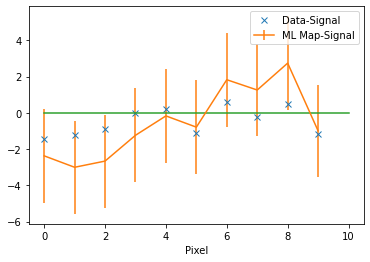

In [17]:
plt.plot(range(npix),(data_map_binned-map_binned),'x',label='Data-Signal')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),(data_map_ml-map_binned),yerr=error,label='ML Map-Signal')
plt.plot([0,10],[0,0])
plt.xlabel('Pixel')
plt.legend()

-0.0006645058264370434 -0.006250740505520333
1.1613472486398106 1.121139106211945


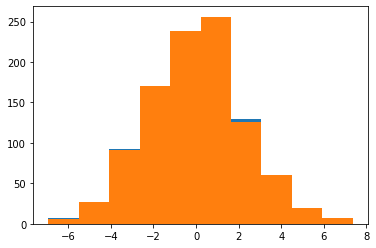

In [18]:
#do a bunch of noise simulations and see how well each estimator does
sn=1
signal = sn*np.sin(2*np.pi*pix/npix)
mean = np.zeros(nsamp)
nsim=1000
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
for i in range(nsim):
    noise = np.random.multivariate_normal(mean, N, size=1).flatten()  # Shape: (100,)
    data=signal+noise
    map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-map_binned
    data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml-map_binned
    delta.append(d2[0])
    deltb.append(d1[0])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
#print(bstd)
plt.hist(bmean)
plt.hist(mlmean)
print(np.mean(bmean),np.mean(mlmean))
print(np.mean(bstd),np.mean(mlstd))
    

In [19]:
# How does this compare to the expected error on the ML Map?
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
print(error)

[2.60920711 2.57216429 2.56795335 2.58556986 2.6003505  2.60124246
 2.58940325 2.5618362  2.58539925 2.53136464]


In [20]:
# It's not quite the same thing, as the historgramed stuff is the std of all 10 points from the "truth" while the 
# predicted noise is the predicted std for one point
print(np.std(delta),np.std(deltb))

2.5351997904715264 2.545089135940185


So the std of the accuracy of the prediction of any one pixel is much larger than the scatter of the mean of all pixels across many simulations. This is because the pixel noise is very correlated,
so if one pixel has large noise so will all the others and all will give a similarly biased high estimate of the signal. So the std of those 10 estimates will be smaller. Probably best then to use the individual pixels std as a benchmark.

# Add in more detectors

In [42]:
import numpy as np

# Define simulation parameters
nsamp = 100  # Number of time samples
npix = 20  # Number of sky pixels
N_det = 3    # Number of detectors
det_spacing = 1  # Separation between detectors in pixels
sigma = 0.5  # Beam width in pixel units

# Simulated pointing locations for the first detector
location = np.linspace(0, npix, nsamp)  # Example: Detector sweeps across pixels
# Extend to multiple detectors (each shifted by det_spacing)
detector_offsets = np.arange(N_det) * det_spacing  # Offsets for each detector

# Initialize the pointing matrix with multiple detectors
Pw = np.zeros((nsamp * N_det, npix))

eps = 1e-12  # Small value to prevent division by zero
# Fill the pointing matrix
for d, offset in enumerate(detector_offsets):  # Loop over detectors
    for i, p in enumerate(location):  # Loop over time samples
        index = i + d * nsamp  # New index for multiple detectors
        for j in range(npix):  # Loop over sky pixels
            Pw[index, j] = np.exp(-0.5 * ((p + offset - j) / sigma) ** 2)  # Gaussian weight
        row_sum = np.sum(Pw[index, :])
        if row_sum > 0:  # Only normalize if row sum is nonzero
            Pw[index, :] /= row_sum
        else:
            print(f"Warning: Row {index} has all zeros and cannot be normalized.")
        #Pw[index, :] /= (np.sum(Pw[index, :]) + eps)  # Add small constant
# Normalize row to sum to 1

# Pw now has shape (nsamp * N_det, npix), meaning all detectors are included



## Signal and Noise
Need to generate 3 copies for the 3 different detectors, so signal has size nsamp*3

In [66]:
## Put in the signal
signal = np.sin(np.linspace(0, 2 * np.pi, npix)) 

## Noise

# Define frequency-domain power spectrum (inverse covariance)
freq = np.fft.rfftfreq(nsamp)
inv_ps = 1 / (1 + (np.maximum(freq, freq[1] / 2) / 0.03) ** -3.5)

# Initialize the full noise correlation matrix F (block-diagonal)
F = np.zeros((nsamp * N_det, nsamp * N_det))

# Identity matrix for impulse response
I = np.eye(nsamp)

# Construct block-diagonal noise covariance (uncorrelated between detectors)
for d in range(N_det):  # Loop over detectors
    for i in range(nsamp):  # Loop over time samples
        row_idx = d * nsamp + i  # Index in full matrix
        col_start = d * nsamp  # Block placement (only within the same detector)

        # Generate noise correlation for a single detector
        noise_corr = np.fft.irfft(inv_ps * np.fft.rfft(I[i]), n=nsamp)

        # Assign to the block-diagonal part of F
        F[row_idx, col_start:col_start + nsamp] = noise_corr

# Add small identity term to avoid singular matrix issues
F += 1e-10 * np.eye(nsamp * N_det)

# Generate correlated noise realizations
L = np.linalg.cholesky(F)  # Cholesky decomposition
white_noise = np.random.randn(nsamp * N_det)  # White noise
correlated_noise = L @ white_noise  # Apply correlation



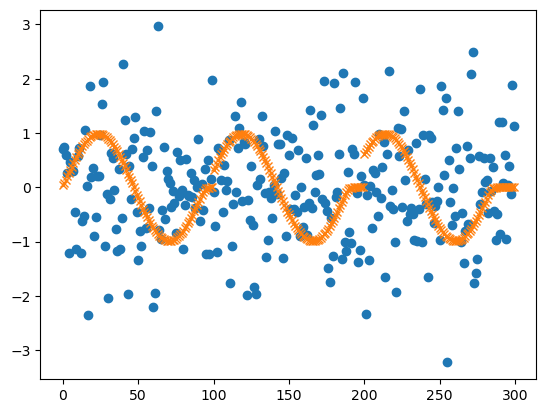

In [67]:
data=Pw.dot(signal)+ correlated_noise
plt.plot(correlated_noise,'o')
plt.plot(Pw.dot(signal),'x')

The zeros at the end are because the detectors are pointing "over the edge" and also the final value of the signal is zero. The first of these problems is evident in that the 3rd detector is the most shifted to the right and therefore sees even less of the actual field with signal. Presumably the inversion should take care of this.

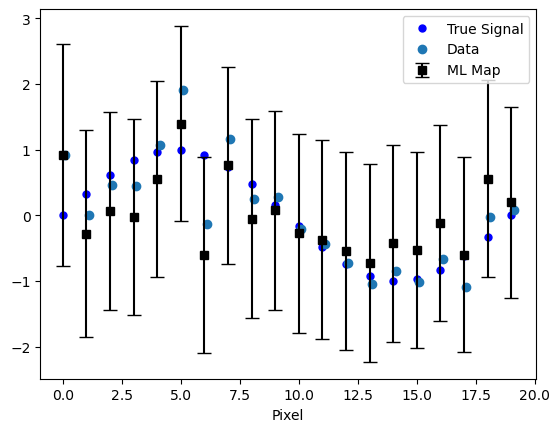

In [68]:
## Plot
#signal_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.dot(signal)) ## Solves P^TP (map) = P^T signal
data_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),signal,'ob',ms=5,label='True Signal')
plt.plot(np.arange(0,npix)+.1,data_map,'o',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml,yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

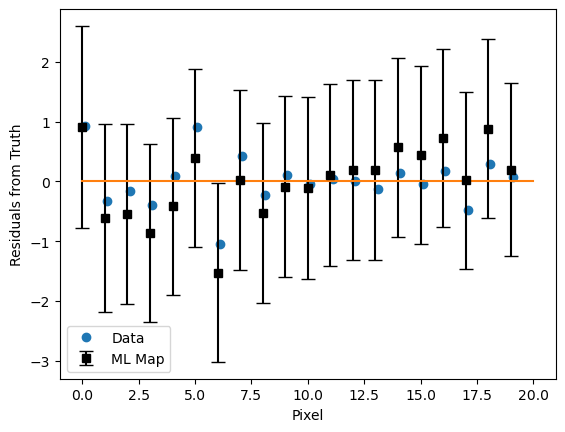

In [69]:
#look at the residuals
plt.plot(np.arange(0,npix)+.1,data_map-signal,'o',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml-signal,yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.ylabel('Residuals from Truth')
plt.plot([0,20],[0,0])
plt.legend()

The error bars there seems too large; let's run simulated noise vectors to see if the spread is accurate

In [70]:
sn=1
signal = sn*np.sin(np.linspace(0, 2 * np.pi, npix)) 
nsim=100
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
for i in range(nsim):
    white_noise = np.random.randn(nsamp * N_det)  # White noise
    correlated_noise = L @ white_noise  # Apply correlation
    data=Pw.dot(signal)+correlated_noise
    #map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-signal#map_binned
    data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml-signal#map_binned
    delta.append(d2[1])
    deltb.append(d1[1])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
delta=np.array(delta)
deltb=np.array(deltb)
print('ML: ',np.mean(delta),np.std(delta))
print('Unweighted: ',np.mean(deltb),np.std(deltb),error[0])

ML:  0.057307978649131154 0.5794026298982238
Unweighted:  0.04536409406343621 0.5331666442432953 1.6877290721710183


### So the error is smaller than the predicted error; also weird that the ML map has a larger std than the unweighted map

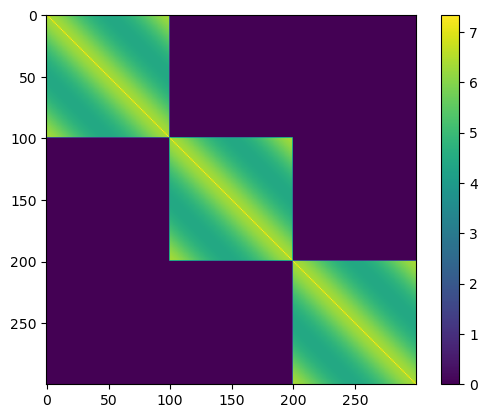

In [71]:
plt.imshow(np.linalg.inv(F))
plt.colorbar()


## Perhaps this has something to do with the periodic boundary conditions, which seem to leadd to unphysical correlations for elements very far from one another.
Maybe try simple noise first.

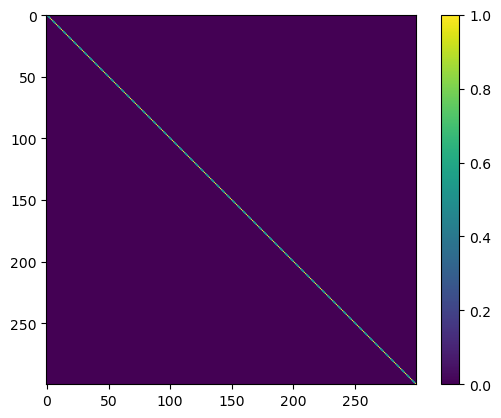

In [108]:
# Identity matrix for the noise matrix
I = np.eye(nsamp*N_det)
F = I
plt.imshow(np.linalg.inv(F))
plt.colorbar()

# Generate correlated noise realizations
L = np.linalg.cholesky(F)  # Cholesky decomposition
white_noise = np.random.randn(nsamp * N_det)  # White noise
correlated_noise = L @ white_noise  # Apply correlation


In [109]:
sn=1
signal = sn*np.sin(np.linspace(0, 2 * np.pi, npix)) 
nsim=100
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
for i in range(nsim):
    white_noise = np.random.randn(nsamp * N_det)  # White noise
    correlated_noise = L @ white_noise  # Apply correlation
    data=Pw.dot(signal)+correlated_noise
    #map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-signal#map_binned
    data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml-signal#map_binned
    delta.append(d2[1])
    deltb.append(d1[1])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
delta=np.array(delta)
deltb=np.array(deltb)
print('ML: ',np.mean(delta),np.std(delta))
print('Unweighted: ',np.mean(deltb),np.std(deltb),error[0],np.mean(bstd))

ML:  -0.07269697722186817 0.5543800947518439
Unweighted:  -0.07269697722186817 0.5543800947518439 0.7913208504185167 0.42986107169257437


Looks like the scatter in an individual pixel is still a factor of 1.5 too small, as is the mean std of all pixels from truth. The problem is that different pixels have different projected errors because of the different coverage. 

In [110]:
print(error)

[0.79132085 0.5653695  0.4508531  0.41991867 0.41537799 0.41474788
 0.41466095 0.41464897 0.41464732 0.41464709 0.41464705 0.41464702
 0.41464684 0.4146455  0.41463581 0.41456546 0.41405506 0.41035211
 0.3834988  0.17331141]


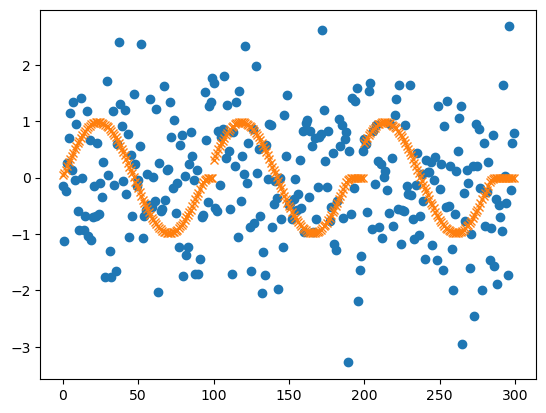

In [111]:
data=Pw.dot(signal)+ correlated_noise
plt.plot(correlated_noise,'o')
plt.plot(Pw.dot(signal),'x')

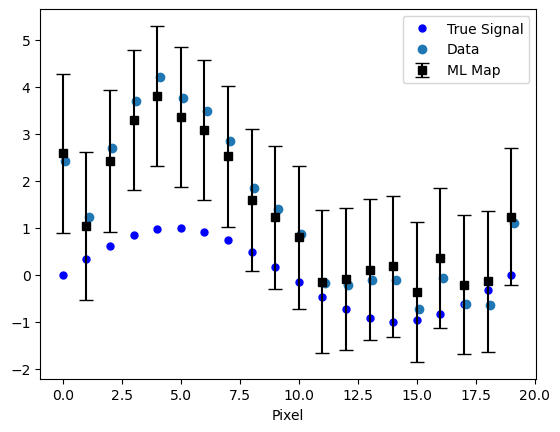

In [129]:
data_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),signal,'ob',ms=5,label='True Signal')
plt.plot(np.arange(0,npix)+.1,data_map,'o',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml,yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

Why is the error on the last pixel so small? Isn't that the pixel that is covered the least?

In [113]:
# Find the rows where the last column is greater than 0.1
for j in range(npix):
    indices = np.where(Pw[:, j] > 0.1)  # Returns tuple (row indices,)
    print(j, np.size(indices))
# Print indices and corresponding elements
#for i in indices[0]:  # Extract row indices from tuple
#    print(f"Index ({i}) -> Element {Pw[i, -1]:.3f}")


0 7
1 17
2 26
3 30
4 30
5 30
6 30
7 30
8 30
9 30
10 30
11 30
12 30
13 30
14 30
15 30
16 30
17 30
18 30
19 45


So the answer is no, in this case the last pixel is covered most often while the first pixel least often

In [114]:
print(error[1],np.std(delta))

0.5653695031252883 0.5543800947518439


very close; Let's try it again with the correlated noise

In [150]:
### Pointing Matrix

N_det=3


det_spacing = 1  # Separation between detectors in pixels
sigma = 0.5  # Beam width in pixel units

# Simulated pointing locations for the first detector
location = np.linspace(0, npix, nsamp)  # Example: Detector sweeps across pixels
# Extend to multiple detectors (each shifted by det_spacing)
detector_offsets = np.arange(N_det) * det_spacing  # Offsets for each detector

# Initialize the pointing matrix with multiple detectors
Pw = np.zeros((nsamp * N_det, npix))

eps = 1e-12  # Small value to prevent division by zero
# Fill the pointing matrix
for d, offset in enumerate(detector_offsets):  # Loop over detectors
    for i, p in enumerate(location):  # Loop over time samples
        index = i + d * nsamp  # New index for multiple detectors
        for j in range(npix):  # Loop over sky pixels
            Pw[index, j] = np.exp(-0.5 * ((p + offset - j) / sigma) ** 2)  # Gaussian weight
        row_sum = np.sum(Pw[index, :])
        if row_sum > 0:  # Only normalize if row sum is nonzero
            Pw[index, :] /= row_sum
        else:
            print(f"Warning: Row {index} has all zeros and cannot be normalized.")
        #Pw[index, :] /= (np.sum(Pw[index, :]) + eps)  # Add small constant


## Noise
# Define frequency-domain power spectrum (inverse covariance)
freq = np.fft.rfftfreq(nsamp)
inv_ps = 1 / (1 + (np.maximum(freq, freq[1] / 2) / 0.03) ** -3.5)

# Initialize the full noise correlation matrix F (block-diagonal)
F = np.zeros((nsamp * N_det, nsamp * N_det))

# Identity matrix for impulse response
I = np.eye(nsamp)

# Construct block-diagonal noise covariance (uncorrelated between detectors)
for d in range(N_det):  # Loop over detectors
    for i in range(nsamp):  # Loop over time samples
        row_idx = d * nsamp + i  # Index in full matrix
        col_start = d * nsamp  # Block placement (only within the same detector)

        # Generate noise correlation for a single detector
        noise_corr = np.fft.irfft(inv_ps * np.fft.rfft(I[i]), n=nsamp)

        # Assign to the block-diagonal part of F
        F[row_idx, col_start:col_start + nsamp] = noise_corr

# Add small identity term to avoid singular matrix issues
F += 1e-10 * np.eye(nsamp * N_det)

# Generate correlated noise realizations
L = np.linalg.cholesky(F)  # Cholesky decomposition

In [151]:
sn=5
signal = sn*np.sin(np.linspace(0, 2 * np.pi, npix)) 
nsim=1000
bmean=[]
bstd=[]
mlmean=[]
mlstd=[]
delta=[]
deltb=[]
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
data_map_ml=np.zeros((npix,nsim))
N = np.linalg.inv(F)  # Compute true noise covariance
L_N = np.linalg.cholesky(N)  # Cholesky decomposition of noise covariance

for i in range(nsim):
    white_noise = np.random.randn(nsamp * N_det)  # White noise
    correlated_noise = L_N @ white_noise  # Apply correlation
    data=Pw.dot(signal)+correlated_noise
    #map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(signal)) ## Solves P^TP (map) = P^T data
    data_map_binned = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
    d1=data_map_binned-signal#map_binned
    data_map_ml[:,i] = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
    d2=data_map_ml[:,i]-signal#map_binned
    delta.append(d2[1])
    deltb.append(d1[1])
    bmean.append(np.mean(d1))
    bstd.append(np.std(d1))
    mlmean.append(np.mean(d2))
    mlstd.append(np.std(d2))
bstd=np.array(bstd)
delta=np.array(delta)
deltb=np.array(deltb)
print('ML: ',np.mean(delta),np.std(delta))
print('Unweighted: ',np.mean(deltb),np.std(deltb),error[1],np.mean(bstd))

ML:  -0.039358748592695454 1.6122885371148683
Unweighted:  -0.052041406530380675 2.1171447229513793 1.5720417241557618 0.9611859856052054


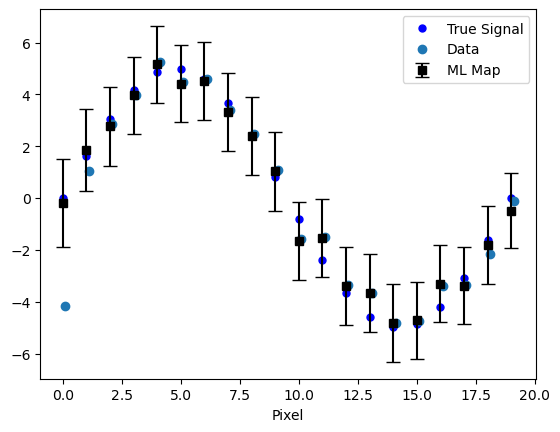

In [152]:
data_map = np.linalg.solve((Pw.T.dot(Pw)), Pw.T.dot(data)) ## Solves P^TP (map) = P^T data
#data_map_ml = np.linalg.solve((Pw.T.dot(F).dot(Pw)),Pw.T.dot(F.dot(data)))
plt.plot(range(npix),signal,'ob',ms=5,label='True Signal')
plt.plot(np.arange(0,npix)+.1,data_map,'o',label='Data')
error=np.sqrt(np.diag(np.linalg.inv(Pw.T.dot(F).dot(Pw))))
plt.errorbar(range(npix),data_map_ml[:,-1],yerr=error,fmt='ks',capsize=5,label='ML Map')
plt.xlabel('Pixel')
plt.legend()

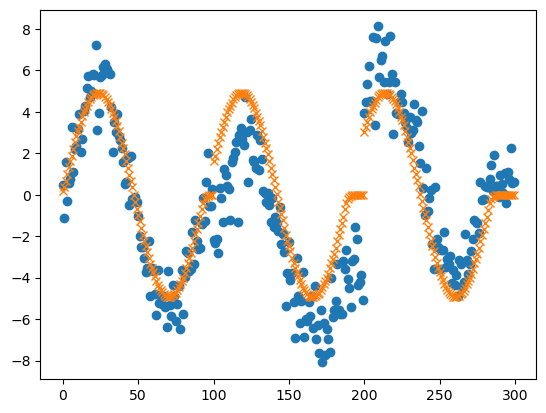

In [138]:
data=Pw.dot(signal)+ correlated_noise
plt.plot(data,'o')
plt.plot(Pw.dot(signal),'x')

ok everything works now

In [127]:
np.linalg.cond(F)

530.0617113710207

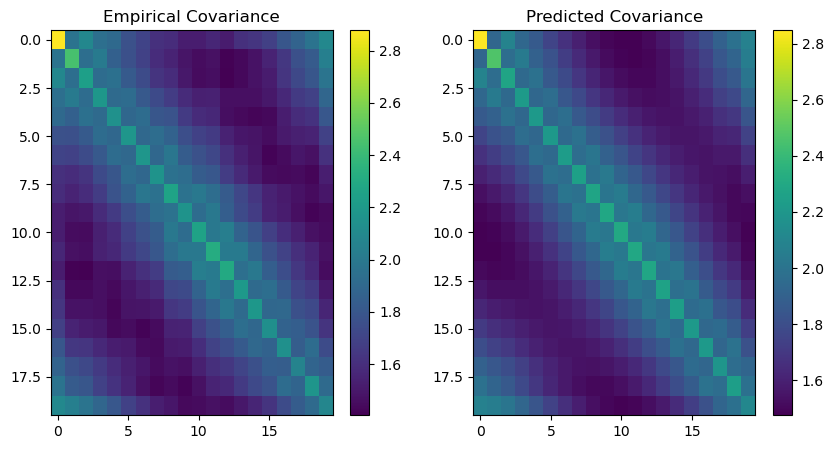

In [128]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(empirical_cov, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Empirical Covariance")

plt.subplot(1,2,2)
plt.imshow(predicted_cov, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Predicted Covariance")

plt.show()

In [122]:
import numpy.linalg as la
print("Condition number of Pw:", la.cond(Pw))


Condition number of Pw: 5.108693624715166
